In [2]:
# ! pip install -U imbalanced-learn
import numpy as np 
import pandas as pd
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from sklearn import metrics
from sklearn.metrics import (
    classification_report,
    accuracy_score,
    confusion_matrix,
    roc_auc_score
)
import matplotlib.pyplot as plt
from scipy.sparse import issparse
from asgmnt_2_tools import lazy_read_parquet
from imblearn.under_sampling import RandomUnderSampler

#### Read in example data file using read parquet

In [3]:
root_path = "../../Data/GoogleDrive/"
df_dict_all = lazy_read_parquet(root_path)
df_heart_drop_05_imp = df_dict_all['df_heart_drop_05_imp'].collect().to_pandas()
df_heart_drop_05_imp

,State,Sex,GeneralHealth,PhysicalHealthDays,MentalHealthDays,LastCheckupTime,PhysicalActivities,SleepHours,RemovedTeeth,HadAsthma,...,HeightInMeters,WeightInKilograms,AlcoholDrinkers,HIVTesting,FluVaxLast12,PneumoVaxEver,TetanusLast10Tdap,HighRiskLastYear,CovidPos,HadHeartDisease
0,Alabama,Female,Very good,0.0,0.0,Within past year (anytime less than 12 months ...,No,8.0,None of them,No,...,1.70,81.19,No,No,Yes,No,"Yes, received tetanus shot but not sure what type",No,No,No
1,Alabama,Female,Excellent,0.0,0.0,Within past year (anytime less than 12 months ...,No,6.0,None of them,No,...,1.60,68.04,No,No,No,No,"No, did not receive any tetanus shot in the pa...",No,No,No
2,Alabama,Female,Very good,2.0,3.0,Within past year (anytime less than 12 months ...,Yes,5.0,None of them,No,...,1.57,63.50,No,No,No,No,"No, did not receive any tetanus shot in the pa...",No,Yes,No
3,Alabama,Female,Excellent,0.0,0.0,Within past year (anytime less than 12 months ...,Yes,7.0,None of them,Yes,...,1.65,63.50,No,No,Yes,Yes,"No, did not receive any tetanus shot in the pa...",No,No,No
4,Alabama,Female,Fair,2.0,0.0,Within past year (anytime less than 12 months ...,Yes,9.0,None of them,No,...,1.57,53.98,Yes,No,No,Yes,"No, did not receive any tetanus shot in the pa...",No,No,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
394695,Virgin Islands,Female,Good,0.0,3.0,Within past 2 years (1 year but less than 2 ye...,Yes,6.0,None of them,Yes,...,1.65,69.85,Yes,Yes,No,No,"No, did not receive any tetanus shot in the pa...",No,Yes,No
394696,Virgin Islands,Female,Excellent,2.0,2.0,Within past year (anytime less than 12 months ...,Yes,7.0,None of them,No,...,1.70,83.01,No,Yes,Yes,No,"Yes, received tetanus shot but not sure what type",No,No,No
394697,Virgin Islands,Female,Poor,30.0,30.0,5 or more years ago,No,5.0,1 to 5,No,...,1.70,49.90,Yes,No,No,No,"No, did not receive any tetanus shot in the pa...",No,No,No
394698,Virgin Islands,Male,Very good,0.0,0.0,Within past year (anytime less than 12 months ...,No,5.0,None of them,Yes,...,1.83,108.86,No,Yes,Yes,Yes,"No, did not receive any tetanus shot in the pa...",No,Yes,Yes


In [4]:
# getting classes in ordinal variables
print(df_heart_drop_05_imp['GeneralHealth'].unique())
print(df_heart_drop_05_imp['LastCheckupTime'].unique())
print(df_heart_drop_05_imp['RemovedTeeth'].unique())
print(df_heart_drop_05_imp['SmokerStatus'].unique())
print(df_heart_drop_05_imp['ECigaretteUsage'].unique())
print(df_heart_drop_05_imp['AgeCategory'].unique())
# print(df_heart_drop_imp['TetanusLast10Tdap'].unique())
print(df_heart_drop_05_imp.info(max_cols=len(df_heart_drop_05_imp.columns)))

['Very good' 'Excellent' 'Fair' 'Poor' 'Good']
['Within past year (anytime less than 12 months ago)'
 'Within past 2 years (1 year but less than 2 years ago)'
 'Within past 5 years (2 years but less than 5 years ago)'
 '5 or more years ago']
['None of them' '1 to 5' '6 or more, but not all' 'All']
['Never smoked' 'Current smoker - now smokes some days' 'Former smoker'
 'Current smoker - now smokes every day']
['Not at all (right now)' 'Never used e-cigarettes in my entire life'
 'Use them every day' 'Use them some days']
['Age 80 or older' 'Age 55 to 59' 'Age 65 to 69' 'Age 40 to 44'
 'Age 75 to 79' 'Age 70 to 74' 'Age 60 to 64' 'Age 50 to 54'
 'Age 45 to 49' 'Age 35 to 39' 'Age 30 to 34' 'Age 25 to 29'
 'Age 18 to 24']
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 394700 entries, 0 to 394699
Data columns (total 37 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   State                      394700 non-nu

#### Encoding and data split

In [4]:
def encode(df):
    """
    Encodes the dataset using one-hot encoding for general categorical columns and 
    ordinal encoding for specified columns with predefined categories. Splits the data into training and test datasets.

    Parameters:
        df (pandas.DataFrame): DataFrame to encode and split.

    Returns:
      X_train_encoded (DataFrame): Encoded training features.
      X_test_encoded (DataFrame): Encoded test features.
      y_train (Series): Training target variable.
      y_test (Series): Test target variable.

    """
    # convert health days from float to int
    # df['PhysicalHealthDays'] = df['PhysicalHealthDays'].astype(int)
    # df['MentalHealthDays'] = df['MentalHealthDays'].astype(int)
    
    # Define the features and target
    X = df.drop('HadHeartDisease', axis=1)
    y = df['HadHeartDisease']

    # data split
    X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                        test_size = 0.25, 
                                        random_state = 69,
                                        stratify = y)

    # Define which columns to one-hot encode and which to label encode
    categorical_cols = X.select_dtypes(include=['object']).columns
    one_hot_cols = categorical_cols.drop(['GeneralHealth', 'LastCheckupTime', 'RemovedTeeth', 
                                          'AgeCategory', 'SmokerStatus', 'ECigaretteUsage'])
    
    # define the columns with specific encoding
    comp_labels = {
        "GeneralHealth": ['Poor', 'Fair', 'Good', 
                          'Very good', 'Excellent'],

        "LastCheckupTime": ['5 or more years ago',
                            'Within past 5 years (2 years but less than 5 years ago)',
                            'Within past 2 years (1 year but less than 2 years ago)',
                            'Within past year (anytime less than 12 months ago)'],

        "RemovedTeeth": ['None of them', '1 to 5',
                         '6 or more, but not all', 'All'],

        "SmokerStatus": ['Never smoked', 'Former smoker',
                         'Current smoker - now smokes some days',
                         'Current smoker - now smokes every day'],
                         
        "ECigaretteUsage": ['Never used e-cigarettes in my entire life',
                            'Not at all (right now)',
                            'Use them some days',
                            'Use them every day']
    }

    label_encoders = [(key + '_label', OrdinalEncoder(categories=[value]), [key]) 
                      for key, value in comp_labels.items()]
    
    # Define the preprocessor
    preprocessor = ColumnTransformer(
        transformers=[
            ('onehot', OneHotEncoder(), one_hot_cols),
            ('label', OrdinalEncoder(), ['AgeCategory']),
        ] + label_encoders
        , remainder='passthrough'
    )
    
    # Fit the preprocessor on the training data only and transform both
    X_train_encoded = preprocessor.fit_transform(X_train)
    X_test_encoded = preprocessor.transform(X_test)

    # fit another label encoder on y
    y_label_encoder = OrdinalEncoder()
    y_train_encoded = y_label_encoder.fit_transform(pd.DataFrame(y_train))
    y_test_encoded = y_label_encoder.transform(pd.DataFrame(y_test))

    # Handle sparse matrix if necessary
    if issparse(X_train_encoded):
        X_train_encoded = X_train_encoded.toarray()
    if issparse(X_test_encoded):
        X_test_encoded = X_test_encoded.toarray()

    # Convert the sparse matrix to DataFrame and specify column names
    X_columns = preprocessor.get_feature_names_out()
    y_column = y_label_encoder.get_feature_names_out()
    X_train_encoded = pd.DataFrame(X_train_encoded, columns=X_columns, index=X_train.index)
    X_test_encoded = pd.DataFrame(X_test_encoded, columns=X_columns, index=X_test.index)
    y_train_encoded = pd.DataFrame(y_train_encoded, columns=y_column, index=y_train.index)
    y_test_encoded = pd.DataFrame(y_test_encoded, columns=y_column, index=y_test.index)
    
    return X_train_encoded, X_test_encoded, y_train_encoded, y_test_encoded

Test encode() on `df_heart_drop_05_imp`

In [145]:
X_train, X_test, y_train, y_test = encode(df_heart_drop_05_imp)
print(X_train.shape)
print(X_test.shape)
print("=============")
print(y_train.shape)
print(y_test.shape)
print("=============")
print(X_train.info())
print("===================================")
print(y_train.info())

Mapping of AgeCategory: {'Age 18 to 24': 0, 'Age 25 to 29': 1, 'Age 30 to 34': 2, 'Age 35 to 39': 3, 'Age 40 to 44': 4, 'Age 45 to 49': 5, 'Age 50 to 54': 6, 'Age 55 to 59': 7, 'Age 60 to 64': 8, 'Age 65 to 69': 9, 'Age 70 to 74': 10, 'Age 75 to 79': 11, 'Age 80 or older': 12}
(296025, 121)
(98675, 121)
(296025, 1)
(98675, 1)
<class 'pandas.core.frame.DataFrame'>
Int64Index: 296025 entries, 260227 to 93175
Columns: 121 entries, onehot__State_Alabama to remainder__WeightInKilograms
dtypes: float64(121)
memory usage: 275.5 MB
None
<class 'pandas.core.frame.DataFrame'>
Int64Index: 296025 entries, 260227 to 93175
Data columns (total 1 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   HadHeartDisease  296025 non-null  float64
dtypes: float64(1)
memory usage: 4.5 MB
None


#### Under sampling to balance data

Function for under sampling

In [5]:
# Only balance the training set
def balance(X_train, y_train):
    yes_count = y_train.value_counts()[1]
    no_count = yes_count * 3
    sampling_strategy = {0: no_count, 1: yes_count}  # A 3:1 ratio
    rus = RandomUnderSampler(sampling_strategy=sampling_strategy) 
    X_train_res, y_train_res = rus.fit_resample(X_train, y_train)
    return X_train_res, y_train_res

distribution of yes and no in target before under sampling

HadHeartDisease
0.0                260572
1.0                 35453
dtype: int64


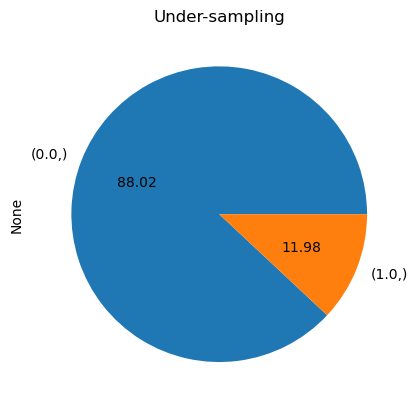

In [8]:
print(y_train.value_counts())
ax = y_train.value_counts().plot.pie(autopct='%.2f')
_ = ax.set_title("Under-sampling")

Distribution of yes and no in target after under sampling

HadHeartDisease
0.0                106359
1.0                 35453
dtype: int64


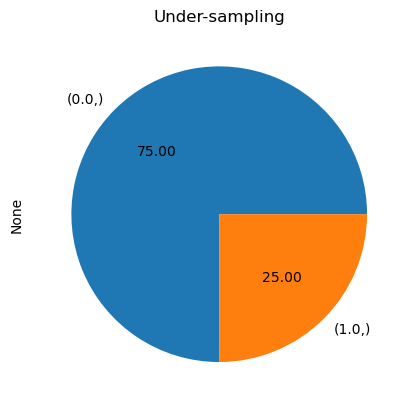

In [11]:
X_train_res, y_train_res = balance(X_train, y_train)
print(y_train_res.value_counts())
ax = y_train_res.value_counts().plot.pie(autopct='%.2f')
_ = ax.set_title("Under-sampling")

#### Threshold Selection

In [6]:
# use logistic regression to select threshold
def logi_reg(X_train_res, X_test, y_train_res, y_test):
    """You know what it does 

        Input: 
            X_train: Encoded features in the training set, a pandas dataframe
            X_test: Encoded features in the test set, a pandas dataframe
            y_train: Target variable of the training set, a pandas series
            y_train: Target variable of the training set, a pandas series

        Output:
            classification_report:
            confusion_matrix:
            accuracy_score:
            roc_auc_score:
    """

    # fit logistic regression model with elastic net regularization
    log_reg = LogisticRegression(penalty = 'elasticnet',
                                solver = 'saga',
                                l1_ratio = 0.5,
                                max_iter = 1000,
                                random_state = 69)
    
    log_reg.fit(X_train_res, y_train_res)

    # predict on test set
    y_test_pred = log_reg.predict(X_test)
    y_pred_proba = log_reg.predict_proba(X_test)[:,1]

    # Evaluate performance
    report = classification_report(y_test, y_test_pred, target_names= ['No', 'Yes'])
    matrix = confusion_matrix(y_test, y_test_pred)
    accuracy = accuracy_score(y_test, y_test_pred)
    roc_auc = roc_auc_score(y_test, y_pred_proba)

    return report, matrix, accuracy, roc_auc


Test if under sampling improves performance on one dataset

In [13]:
report, matrix, accuracy, roc_auc = logi_reg(X_train_res, X_test, y_train_res, y_test)
print (f"The threshold for removing NAs is 5")
print('\n===============================\n'+
    'Classification report on test data' +
    '\n===============================\n')
print(report)

print('\n===============================\n'+
    'Confusion matrix on test data' +
    '\n===============================\n')
print(matrix)

print("Accuracy:", accuracy)
print("ROC AUC:", roc_auc)
print("=====================================\n")

/Users/xiaogouzuomeng/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/xiaogouzuomeng/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


The threshold for removing NAs is 5

Classification report on test data

              precision    recall  f1-score   support

          No       0.93      0.92      0.92     86858
         Yes       0.43      0.46      0.45     11817

    accuracy                           0.86     98675
   macro avg       0.68      0.69      0.68     98675
weighted avg       0.87      0.86      0.86     98675


Confusion matrix on test data

[[79711  7147]
 [ 6368  5449]]
Accuracy: 0.8630352166202179
ROC AUC: 0.8440294522476228



#### Run a loop over thresholds and print out evaluation

Apply `encode()`, `balance()` and `logi_reg()` on all datasets and see which one has best performance

In [14]:
root_path = "../../Data/GoogleDrive/"
df_dict_all = lazy_read_parquet(root_path)
thresholds = [0, 1, 3, 5, 10, 20, 40]
# for creating plots later
roc_list = []
for threshold in thresholds:
    # loop through each dataset
    df = df_dict_all[f'df_heart_drop_{threshold:02}_imp'].collect().to_pandas()
    # split and encode
    X_train, X_test, y_train, y_test = encode(df)
    # under sampling to training set
    X_train_res, y_train_res = balance(X_train, y_train)
    # run logistic regression
    report, matrix, accuracy, roc_auc = logi_reg(X_train_res, X_test, y_train_res, y_test)
    roc_list.append(roc_auc)
    print (f"The threshold for removing NAs is {threshold:02}")
    print('Shape of the dataset: ' + str(df.shape))
    print('\n===============================\n'+
        'Classification report on test data' +
        '\n===============================\n')
    print(report)

    print('\n===============================\n'+
        'Confusion matrix on test data' +
        '\n===============================\n')
    print(matrix)

    print("Accuracy:", accuracy)
    print("ROC AUC:", roc_auc)
    print("=====================================\n")

/Users/xiaogouzuomeng/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/xiaogouzuomeng/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


The threshold for removing NAs is 00
Shape of the dataset: (248265, 37)

Classification report on test data

              precision    recall  f1-score   support

          No       0.93      0.92      0.92     54780
         Yes       0.41      0.44      0.43      7287

    accuracy                           0.86     62067
   macro avg       0.67      0.68      0.67     62067
weighted avg       0.87      0.86      0.86     62067


Confusion matrix on test data

[[50202  4578]
 [ 4059  3228]]
Accuracy: 0.8608439267243463
ROC AUC: 0.8363967465856289



/Users/xiaogouzuomeng/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/xiaogouzuomeng/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


The threshold for removing NAs is 01
Shape of the dataset: (342961, 37)

Classification report on test data

              precision    recall  f1-score   support

          No       0.93      0.92      0.92     75609
         Yes       0.42      0.45      0.44     10132

    accuracy                           0.86     85741
   macro avg       0.67      0.68      0.68     85741
weighted avg       0.87      0.86      0.86     85741


Confusion matrix on test data

[[69298  6311]
 [ 5548  4584]]
Accuracy: 0.8616881072065873
ROC AUC: 0.8398949836447667



/Users/xiaogouzuomeng/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/xiaogouzuomeng/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


The threshold for removing NAs is 03
Shape of the dataset: (387487, 37)

Classification report on test data

              precision    recall  f1-score   support

          No       0.92      0.92      0.92     85306
         Yes       0.42      0.45      0.43     11566

    accuracy                           0.86     96872
   macro avg       0.67      0.68      0.68     96872
weighted avg       0.86      0.86      0.86     96872


Confusion matrix on test data

[[78058  7248]
 [ 6371  5195]]
Accuracy: 0.8594124205136675
ROC AUC: 0.8388180524093795



/Users/xiaogouzuomeng/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/xiaogouzuomeng/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


The threshold for removing NAs is 05
Shape of the dataset: (394700, 37)

Classification report on test data

              precision    recall  f1-score   support

          No       0.93      0.92      0.92     86858
         Yes       0.43      0.46      0.45     11817

    accuracy                           0.86     98675
   macro avg       0.68      0.69      0.68     98675
weighted avg       0.87      0.86      0.87     98675


Confusion matrix on test data

[[79740  7118]
 [ 6375  5442]]
Accuracy: 0.8632581707626045
ROC AUC: 0.8439477814375365



/Users/xiaogouzuomeng/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/xiaogouzuomeng/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


The threshold for removing NAs is 10
Shape of the dataset: (412908, 37)

Classification report on test data

              precision    recall  f1-score   support

          No       0.92      0.92      0.92     90857
         Yes       0.43      0.45      0.44     12370

    accuracy                           0.86    103227
   macro avg       0.68      0.69      0.68    103227
weighted avg       0.87      0.86      0.86    103227


Confusion matrix on test data

[[83401  7456]
 [ 6773  5597]]
Accuracy: 0.8621581562963179
ROC AUC: 0.8409824782712862



/Users/xiaogouzuomeng/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/xiaogouzuomeng/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


The threshold for removing NAs is 20
Shape of the dataset: (439673, 37)

Classification report on test data

              precision    recall  f1-score   support

          No       0.92      0.92      0.92     96864
         Yes       0.43      0.44      0.43     13055

    accuracy                           0.86    109919
   macro avg       0.67      0.68      0.68    109919
weighted avg       0.86      0.86      0.86    109919


Confusion matrix on test data

[[89088  7776]
 [ 7302  5753]]
Accuracy: 0.8628262629754637
ROC AUC: 0.8397465636888329



/Users/xiaogouzuomeng/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/xiaogouzuomeng/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


The threshold for removing NAs is 40
Shape of the dataset: (439952, 37)

Classification report on test data

              precision    recall  f1-score   support

          No       0.92      0.92      0.92     96924
         Yes       0.42      0.45      0.43     13064

    accuracy                           0.86    109988
   macro avg       0.67      0.68      0.68    109988
weighted avg       0.86      0.86      0.86    109988


Confusion matrix on test data

[[88954  7970]
 [ 7248  5816]]
Accuracy: 0.8616394515765357
ROC AUC: 0.838171978304325



In [15]:
roc_list

[0.8363967465856289,
 0.8398949836447667,
 0.8388180524093795,
 0.8439477814375365,
 0.8409824782712862,
 0.8397465636888329,
 0.838171978304325]

#### Bar Plot of ROC AUC against thresholds

roc auc as y-axis, thresholds as x-axis

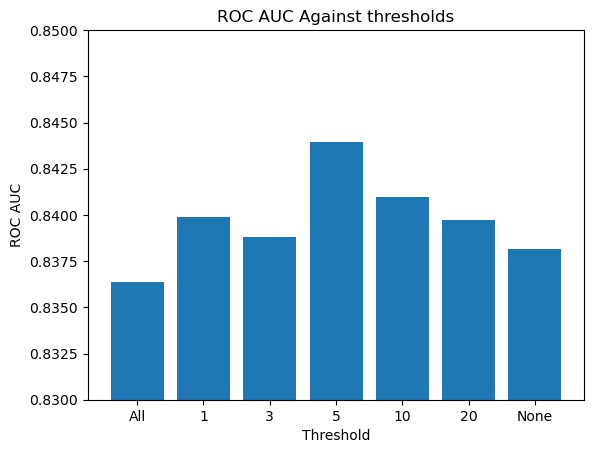

In [16]:
thresholds = ['All', '1', '3', '5', '10', '20', 'None']
# Create bar plot
plt.bar(thresholds, roc_list)
plt.ylim(0.83, 0.85)

# Adding the title and labels
plt.title('ROC AUC Against thresholds')
plt.xlabel('Threshold')
plt.ylabel('ROC AUC')

# Show the plot
plt.show()

Threshold = 5 results the best performance on logit.

#### Reapply functions on the final dataset again and export

In [17]:
df_heart_drop_05_imp = df_dict_all['df_heart_drop_05_imp'].collect().to_pandas()
df_heart_drop_05_imp

,State,Sex,GeneralHealth,PhysicalHealthDays,MentalHealthDays,LastCheckupTime,PhysicalActivities,SleepHours,RemovedTeeth,HadAsthma,...,HeightInMeters,WeightInKilograms,AlcoholDrinkers,HIVTesting,FluVaxLast12,PneumoVaxEver,TetanusLast10Tdap,HighRiskLastYear,CovidPos,HadHeartDisease
0,Alabama,Female,Very good,0.0,0.0,Within past year (anytime less than 12 months ...,No,8.0,None of them,No,...,1.70,81.19,No,No,Yes,No,"Yes, received tetanus shot but not sure what type",No,No,No
1,Alabama,Female,Excellent,0.0,0.0,Within past year (anytime less than 12 months ...,No,6.0,None of them,No,...,1.60,68.04,No,No,No,No,"No, did not receive any tetanus shot in the pa...",No,No,No
2,Alabama,Female,Very good,2.0,3.0,Within past year (anytime less than 12 months ...,Yes,5.0,None of them,No,...,1.57,63.50,No,No,No,No,"No, did not receive any tetanus shot in the pa...",No,Yes,No
3,Alabama,Female,Excellent,0.0,0.0,Within past year (anytime less than 12 months ...,Yes,7.0,None of them,Yes,...,1.65,63.50,No,No,Yes,Yes,"No, did not receive any tetanus shot in the pa...",No,No,No
4,Alabama,Female,Fair,2.0,0.0,Within past year (anytime less than 12 months ...,Yes,9.0,None of them,No,...,1.57,53.98,Yes,No,No,Yes,"No, did not receive any tetanus shot in the pa...",No,No,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
394695,Virgin Islands,Female,Good,0.0,3.0,Within past 2 years (1 year but less than 2 ye...,Yes,6.0,None of them,Yes,...,1.65,69.85,Yes,Yes,No,No,"No, did not receive any tetanus shot in the pa...",No,Yes,No
394696,Virgin Islands,Female,Excellent,2.0,2.0,Within past year (anytime less than 12 months ...,Yes,7.0,None of them,No,...,1.70,83.01,No,Yes,Yes,No,"Yes, received tetanus shot but not sure what type",No,No,No
394697,Virgin Islands,Female,Poor,30.0,30.0,5 or more years ago,No,5.0,1 to 5,No,...,1.70,49.90,Yes,No,No,No,"No, did not receive any tetanus shot in the pa...",No,No,No
394698,Virgin Islands,Male,Very good,0.0,0.0,Within past year (anytime less than 12 months ...,No,5.0,None of them,Yes,...,1.83,108.86,No,Yes,Yes,Yes,"No, did not receive any tetanus shot in the pa...",No,Yes,Yes


In [18]:
# split and encode
X_train, X_test, y_train, y_test = encode(df_heart_drop_05_imp)
# under sampling to training set
X_train_res, y_train_res = balance(X_train, y_train)

X_train_res.to_parquet(root_path + "X_train.parquet")
X_test.to_parquet(root_path + "X_test.parquet")
y_train_res.to_parquet(root_path + "y_train.parquet")
y_test.to_parquet(root_path + "y_test.parquet")

Test read in parquet

In [7]:
root_path = "../../Data/GoogleDrive/"
X_train = pd.read_parquet(root_path + "X_train.parquet")
X_train

,onehot__State_Alabama,onehot__State_Alaska,onehot__State_Arizona,onehot__State_Arkansas,onehot__State_California,onehot__State_Colorado,onehot__State_Connecticut,onehot__State_Delaware,onehot__State_District of Columbia,onehot__State_Florida,...,GeneralHealth_label__GeneralHealth,LastCheckupTime_label__LastCheckupTime,RemovedTeeth_label__RemovedTeeth,SmokerStatus_label__SmokerStatus,ECigaretteUsage_label__ECigaretteUsage,remainder__PhysicalHealthDays,remainder__MentalHealthDays,remainder__SleepHours,remainder__HeightInMeters,remainder__WeightInKilograms
260047,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2.0,3.0,0.0,0.0,0.0,0.0,0.0,7.0,1.57,58.97
83371,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,3.0,2.0,0.0,3.0,1.0,30.0,0.0,7.0,1.83,72.57
212930,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,4.0,3.0,0.0,0.0,0.0,1.0,0.0,8.0,1.80,81.65
368200,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2.0,3.0,1.0,0.0,0.0,0.0,0.0,8.0,1.60,77.56
36720,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,3.0,0.0,0.0,1.0,0.0,5.0,5.0,7.0,1.85,83.91
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
218110,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,4.0,3.0,3.0,1.0,1.0,0.0,0.0,10.0,1.63,72.57
333761,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,3.0,1.0,0.0,0.0,0.0,14.0,6.0,1.70,70.31
142329,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,3.0,2.0,1.0,0.0,0.0,0.0,5.0,1.78,97.52
370022,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,3.0,3.0,1.0,0.0,0.0,0.0,12.0,1.75,77.11


In [8]:
y_train = pd.read_parquet(root_path + "y_train.parquet")
y_train

,HadHeartDisease
260047,0.0
83371,0.0
212930,0.0
368200,0.0
36720,0.0
...,...
218110,1.0
333761,1.0
142329,1.0
370022,1.0


#### EDA

Distribution of target variable in train before undersampling

HadHeartDisease
0.0                260572
1.0                 35453
dtype: int64


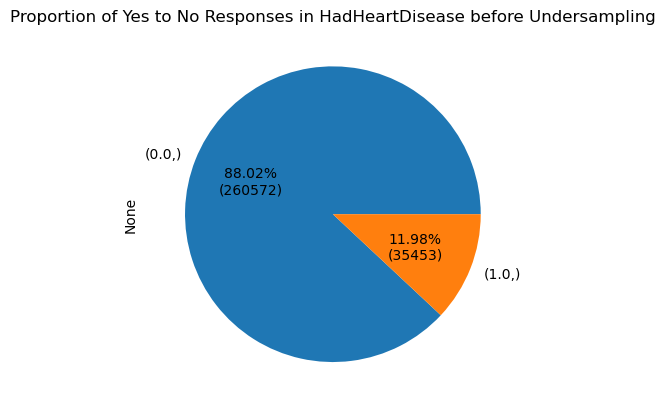

In [9]:
X_train, X_test, y_train, y_test = encode(df_heart_drop_05_imp)
data = y_train.value_counts()
print(y_train.value_counts())

# Function to calculate percentage and absolute value
def func(pct, allvals):
    absolute = int(pct/100.*np.sum(allvals)) + 1
    return "{:.2f}%\n({:d})".format(pct, absolute)

# Plotting the pie chart
fig, ax = plt.subplots()
data.plot.pie(autopct=lambda pct: func(pct, data), ax=ax)

# Optional: set aspect of the plot to be equal, so the pie is drawn as a circle.
ax.set_aspect('equal')
plt.title('Proportion of Yes to No Responses in HadHeartDisease before Undersampling')
plt.show()

Distribution of target variable in train after undersampling

HadHeartDisease
0.0                106359
1.0                 35453
dtype: int64


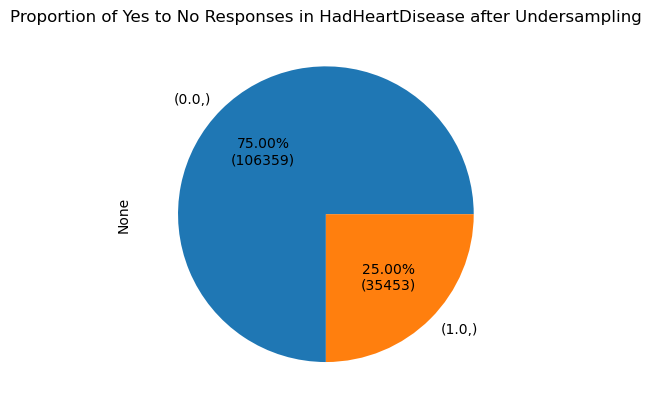

In [10]:
y_train = pd.read_parquet(root_path + "y_train.parquet")
data = y_train.value_counts()
print(y_train.value_counts())

# Function to calculate percentage and absolute value
def func(pct, allvals):
    absolute = int(pct/100.*np.sum(allvals))
    return "{:.2f}%\n({:d})".format(pct, absolute)

# Plotting the pie chart
fig, ax = plt.subplots()
data.plot.pie(autopct=lambda pct: func(pct, data), ax=ax)

# Optional: set aspect of the plot to be equal, so the pie is drawn as a circle.
ax.set_aspect('equal')
plt.title('Proportion of Yes to No Responses in HadHeartDisease after Undersampling')
plt.show()

HadHeartDisease
0.0                86858
1.0                11817
dtype: int64


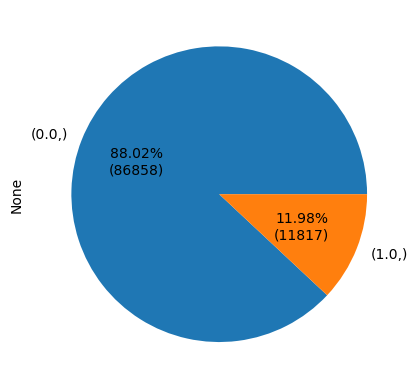

In [27]:
y_test = pd.read_parquet(root_path + "y_test.parquet")
data = y_test.value_counts()
print(y_test.value_counts())

# Function to calculate percentage and absolute value
def func(pct, allvals):
    absolute = int(pct/100.*np.sum(allvals))
    return "{:.2f}%\n({:d})".format(pct, absolute)

# Plotting the pie chart
fig, ax = plt.subplots()
data.plot.pie(autopct=lambda pct: func(pct, data), ax=ax)

# Optional: set aspect of the plot to be equal, so the pie is drawn as a circle.
ax.set_aspect('equal')

plt.show()

Combine the data back for EDA

In [11]:
combined_df = pd.concat([X_train, y_train], axis=1)
combined_df.reset_index(drop=True, inplace=True)

/Users/xiaogouzuomeng/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Users/xiaogouzuomeng/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Users/xiaogouzuomeng/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misi

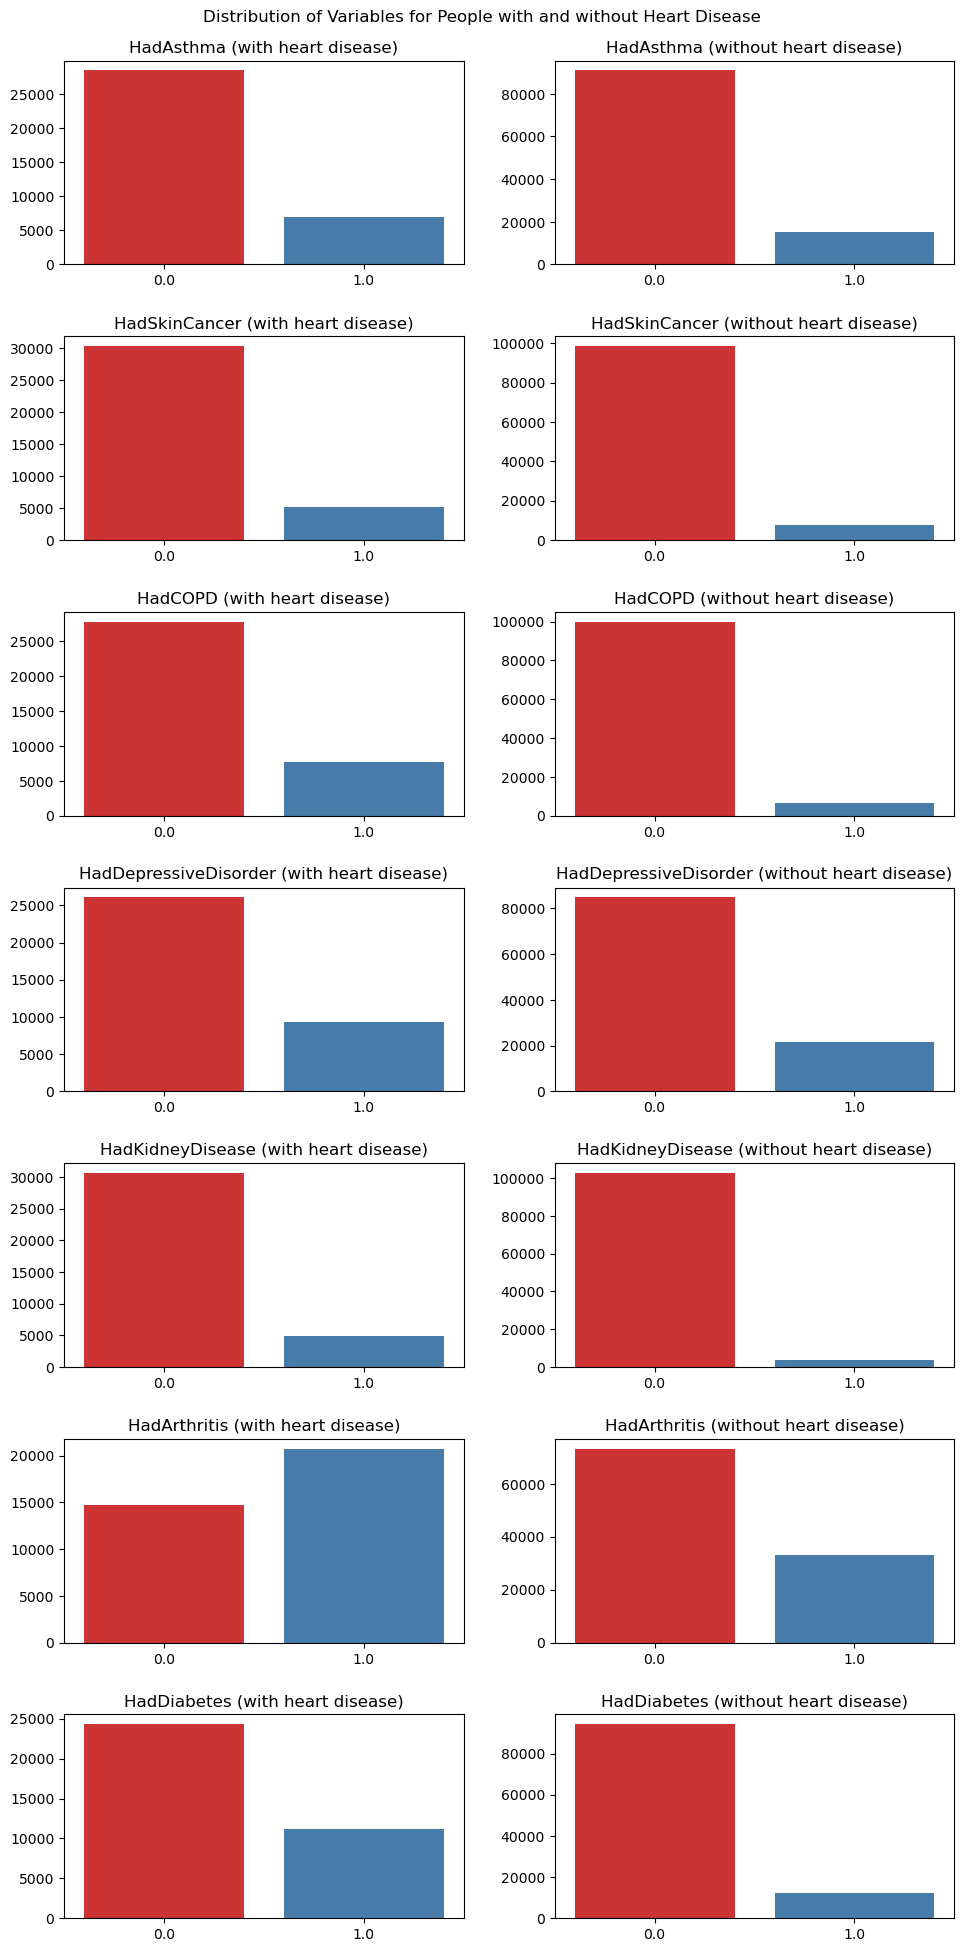

In [12]:
# get all columns that start with "had" and have "yes"
# 1 stands for have disease, 0 stands for no disease
had_cols = [col for col in combined_df.columns if 'Had' in col and 'Yes' in col][:-1]
# group dataset by HadHeartDisease
heart_yes = combined_df[combined_df['HadHeartDisease'] == 1]
heart_no = combined_df[combined_df['HadHeartDisease'] == 0]

# plot the distribution of the variables for people who have heart disease
fig, axes = plt.subplots(nrows = 7, ncols = 2)
fig.set_size_inches(10,20)
fig.suptitle('Distribution of Variables for People with and without Heart Disease', fontsize=12)

for i, col in enumerate(had_cols):
    sns.countplot(heart_yes[col], ax = axes[i, 0], 
                  palette = 'Set1')
    sns.countplot(heart_no[col], ax = axes[i, 1], 
                  palette = 'Set1')
    
    axes[i, 0].set_title(col.replace('onehot__', '').replace('_Yes', ' (with heart disease)'))
    axes[i, 0].set_xlabel('')
    axes[i, 0].set_ylabel('')
    axes[i, 1].set_title(col.replace('onehot__', '').replace('_Yes', ' (without heart disease)'))
    axes[i, 1].set_xlabel('')
    axes[i, 1].set_ylabel('')
plt.tight_layout(pad=2.0)
plt.show()

               HadHeartDisease    Condition  HasCondition
3        Without Heart Disease    HadAsthma           1.0
8        Without Heart Disease    HadAsthma           1.0
10                         NaN    HadAsthma           1.0
42       Without Heart Disease    HadAsthma           1.0
50                         NaN    HadAsthma           1.0
...                        ...          ...           ...
2072143  Without Heart Disease  HadDiabetes           1.0
2072149  Without Heart Disease  HadDiabetes           1.0
2072152  Without Heart Disease  HadDiabetes           1.0
2072164                    NaN  HadDiabetes           1.0
2072167     With Heart Disease  HadDiabetes           1.0

[309953 rows x 3 columns]


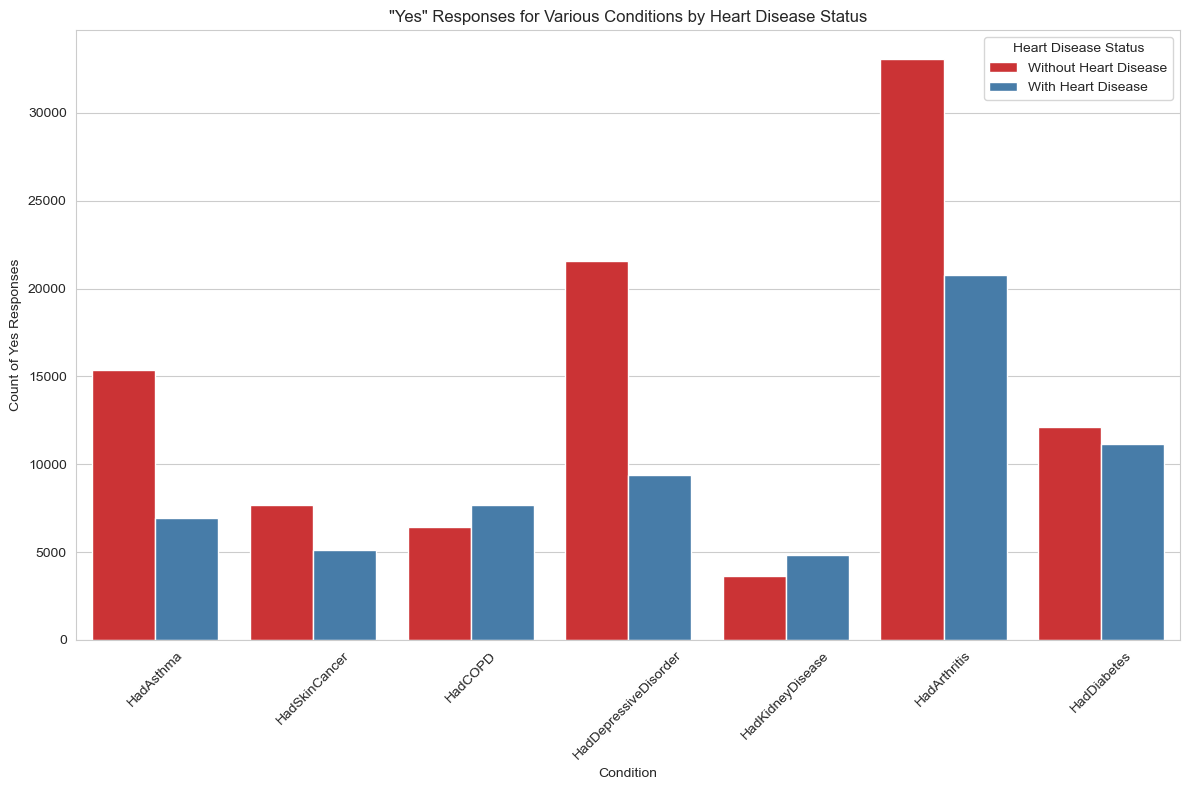

In [13]:


# Filter columns that start with 'Had' and include 'Yes', and exclude the target variable if it's in the same format
had_cols = [col for col in combined_df.columns if 'Had' in col and 'Yes' in col][:-1]

# Melt the DataFrame to long format for easier plotting
long_format = combined_df.melt(id_vars='HadHeartDisease', value_vars=had_cols,
                               var_name='Condition', value_name='HasCondition')

# Rename and filter for 'Yes' only in HasCondition
long_format['Condition'] = long_format['Condition'].str.replace('onehot__', '').str.replace('_Yes', '')
long_format = long_format[long_format['HasCondition'] == 1]  # Filter only 'Yes' responses

# Convert HadHeartDisease to a more readable format
long_format['HadHeartDisease'] = long_format['HadHeartDisease'].map({1: 'With Heart Disease', 0: 'Without Heart Disease'})
print(long_format)
# Plotting
sns.set_style("whitegrid")
plt.figure(figsize=(12, 8))
sns.countplot(data=long_format, x='Condition', hue='HadHeartDisease', palette='Set1')
plt.title('"Yes" Responses for Various Conditions by Heart Disease Status')
plt.xticks(rotation=45)  # Rotate the x labels for better readability
plt.xlabel('Condition')
plt.ylabel('Count of Yes Responses')
plt.legend(title='Heart Disease Status')
plt.tight_layout()
plt.show()

                Condition      prop HadHeartDisease
0               HadAsthma  0.195555             Yes
1           HadSkinCancer  0.145037             Yes
2                 HadCOPD  0.216286             Yes
3   HadDepressiveDisorder  0.264406             Yes
4        HadKidneyDisease  0.136039             Yes
5            HadArthritis  0.414351             Yes
6             HadDiabetes  0.314360             Yes
7               HadAsthma  0.144576              No
8           HadSkinCancer  0.072086              No
9                 HadCOPD  0.060239              No
10  HadDepressiveDisorder  0.202823              No
11       HadKidneyDisease  0.033998              No
12           HadArthritis  0.310684              No
13            HadDiabetes  0.113681              No


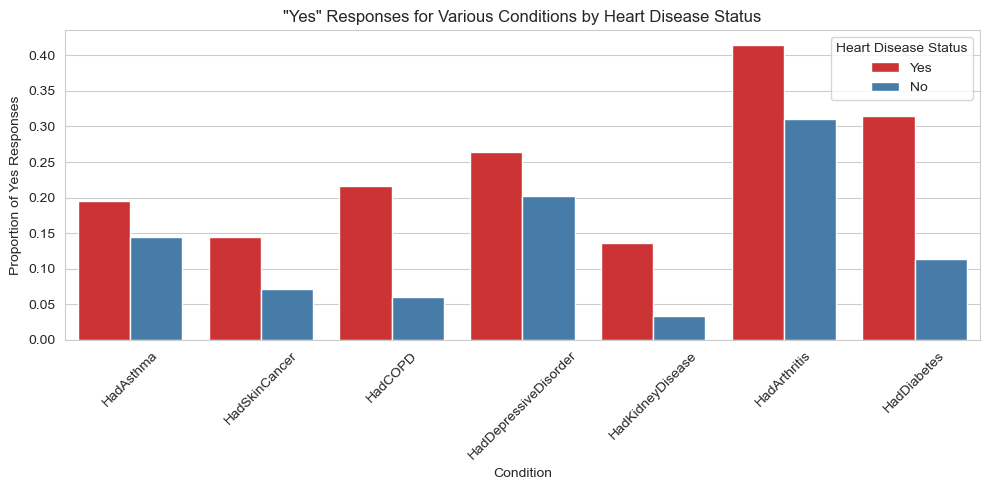

In [29]:
# Filter columns that start with 'Had' and include 'Yes', and exclude the target variable if it's in the same format
had_cols = [col for col in combined_df.columns if 'Had' in col and 'Yes' in col][:-1]
# group dataset by HadHeartDisease
heart_yes = combined_df[combined_df['HadHeartDisease'] == 1]
heart_no = combined_df[combined_df['HadHeartDisease'] == 0]
for col in had_cols:
    prop_yes = heart_yes[col].value_counts()/len(heart_yes[col])
    prop_no = heart_no[col].value_counts()/len(heart_no[col])
    #print(prop_yes)
    #print(prop_no)
data = {'Condition': ['HadAsthma', 'HadSkinCancer', 'HadCOPD', 'HadDepressiveDisorder', 'HadKidneyDisease', 'HadArthritis', 'HadDiabetes',
                      'HadAsthma', 'HadSkinCancer', 'HadCOPD', 'HadDepressiveDisorder', 'HadKidneyDisease', 'HadArthritis', 'HadDiabetes'],
        'prop': [0.195555, 0.145037, 0.216286, 0.264406, 0.136039, 0.414351, 0.31436,
                      0.144576, 0.072086, 0.060239, 0.202823, 0.033998, 0.310684, 0.113681],
        'HadHeartDisease': [1, 1, 1, 1, 1, 1, 1,
                            0, 0, 0, 0, 0, 0, 0]}
plot_data = pd.DataFrame(data)
plot_data['HadHeartDisease'] = plot_data['HadHeartDisease'].map({1: 'Yes', 0: 'No'})
print(plot_data)

sns.set_style("whitegrid")
plt.figure(figsize=(10, 5))
sns.barplot(data=plot_data, x='Condition', y='prop', hue='HadHeartDisease', palette='Set1')
plt.title('"Yes" Responses for Various Conditions by Heart Disease Status')
plt.xticks(rotation=45)  # Rotate the x labels for better readability
plt.xlabel('Condition')
plt.ylabel('Proportion of Yes Responses')
plt.legend(title='Heart Disease Status')
plt.tight_layout()
plt.show()

['label__AgeCategory']


/Users/xiaogouzuomeng/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0.5, 1.0, 'Distribution of AgeCategory for People with Heart Disease')

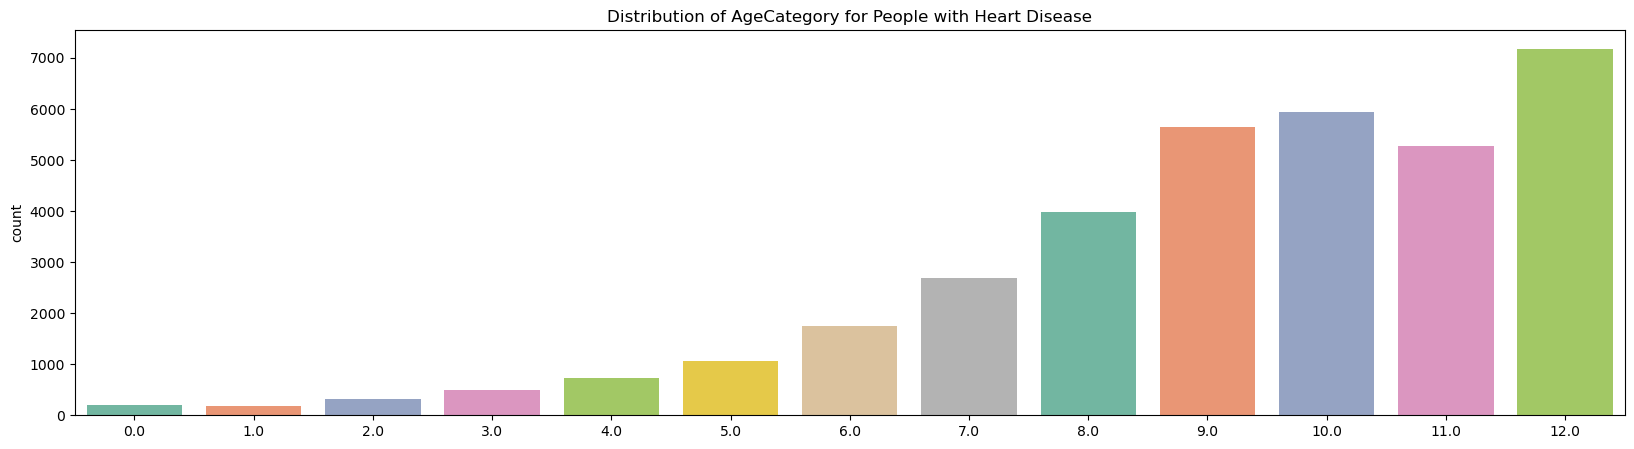

In [87]:
# get all columns that represent an age category
age_cols = [col for col in combined_df.columns if 'AgeCategory' in col]
print(age_cols)
age_yes = combined_df[combined_df['HadHeartDisease'] == 1]['label__AgeCategory']
age_no = combined_df[combined_df['HadHeartDisease'] == 0]['label__AgeCategory']

# see proportion for AgeCategory
plt.figure(figsize=(20,5))
sns.countplot(age_yes, palette = 'Set2')
plt.xlabel('')
plt.title('Distribution of AgeCategory for People with Heart Disease')

/Users/xiaogouzuomeng/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0.5, 1.0, 'Distribution of AgeCategory for People without Heart Disease')

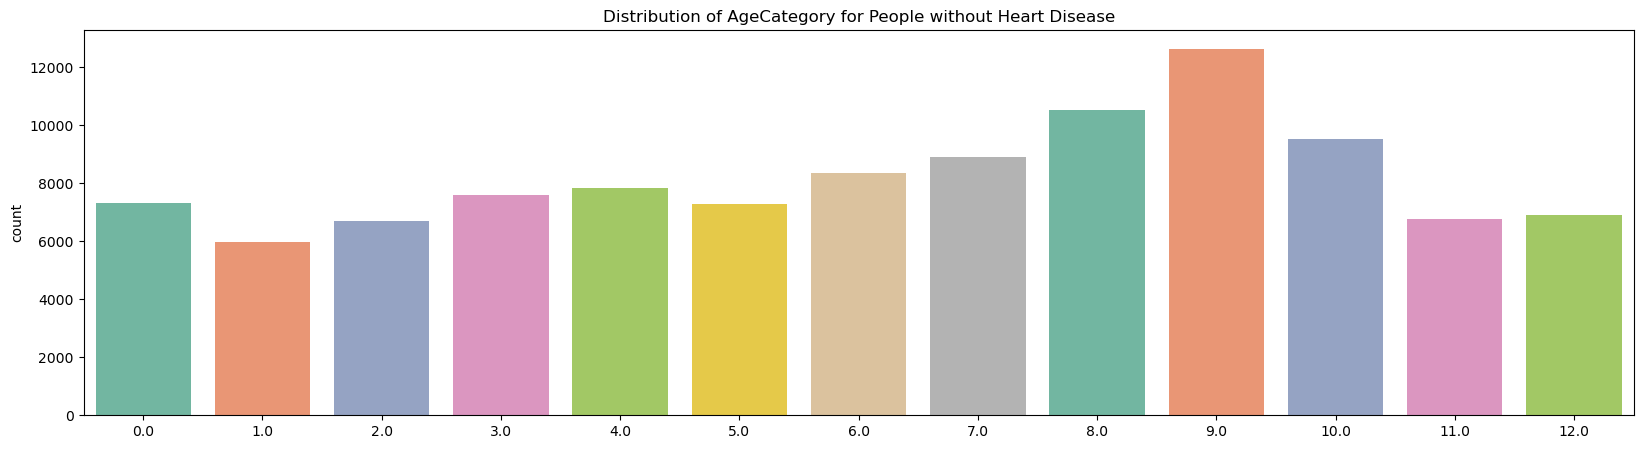

In [61]:
# see proportion for AgeCategory
plt.figure(figsize=(20,5))
sns.countplot(age_no, palette = 'Set2')
plt.xlabel('')
plt.title('Distribution of AgeCategory for People without Heart Disease')

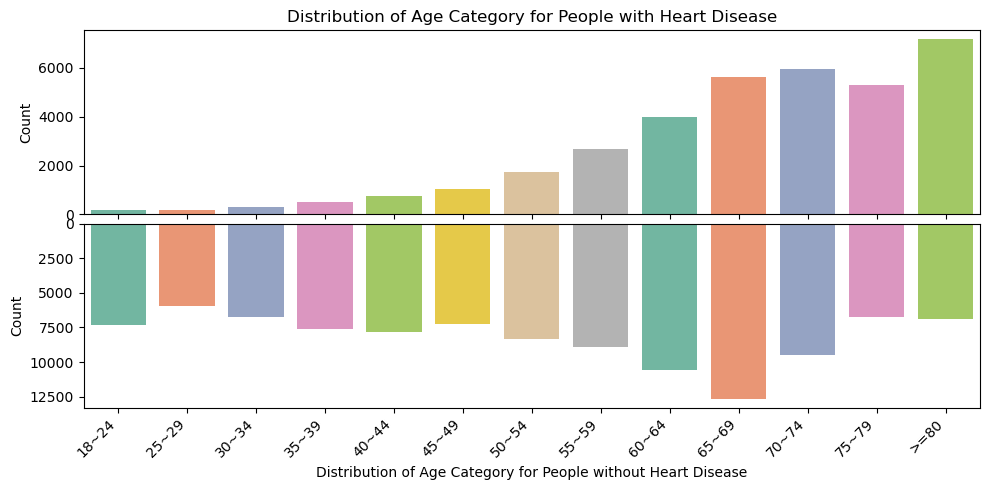

In [140]:

# Simplifying the labels
labels = ['18~24', '25~29', '30~34', '35~39', '40~44', '45~49', '50~54', '55~59', '60~64', '65~69', '70~74', '75~79', '>=80']

fig, axes = plt.subplots(2, 1, figsize=(10, 5), sharex=True, dpi=100)  # Changes here: 2 rows, 1 column

# Plot for people with heart disease
sns.countplot(x=age_yes, palette='Set2', ax=axes[0])  # Use ax=axes[0] for the first subplot
axes[0].set_title('Distribution of Age Category for People with Heart Disease')
axes[0].set_ylabel('Count')
axes[0].set_xlabel('')

# Plot for people without heart disease
sns.countplot(x=age_no, palette='Set2', ax=axes[1])  # Use ax=axes[1] for the second subplot
axes[1].set_ylabel('Count')
axes[1].set_xlabel('Distribution of Age Category for People without Heart Disease')
axes[1].invert_yaxis()  # Invert the second plot
# Set the custom x-axis labels
plt.xticks(range(len(labels)), labels, rotation=45, ha='right')  # Rotate for better legibility

plt.tight_layout()  # Adjust layout to prevent overlap
plt.subplots_adjust(hspace=0.05) 
plt.show()

/Users/xiaogouzuomeng/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0.5, 1.0, 'Distribution of GeneralHealth for People with Heart Disease')

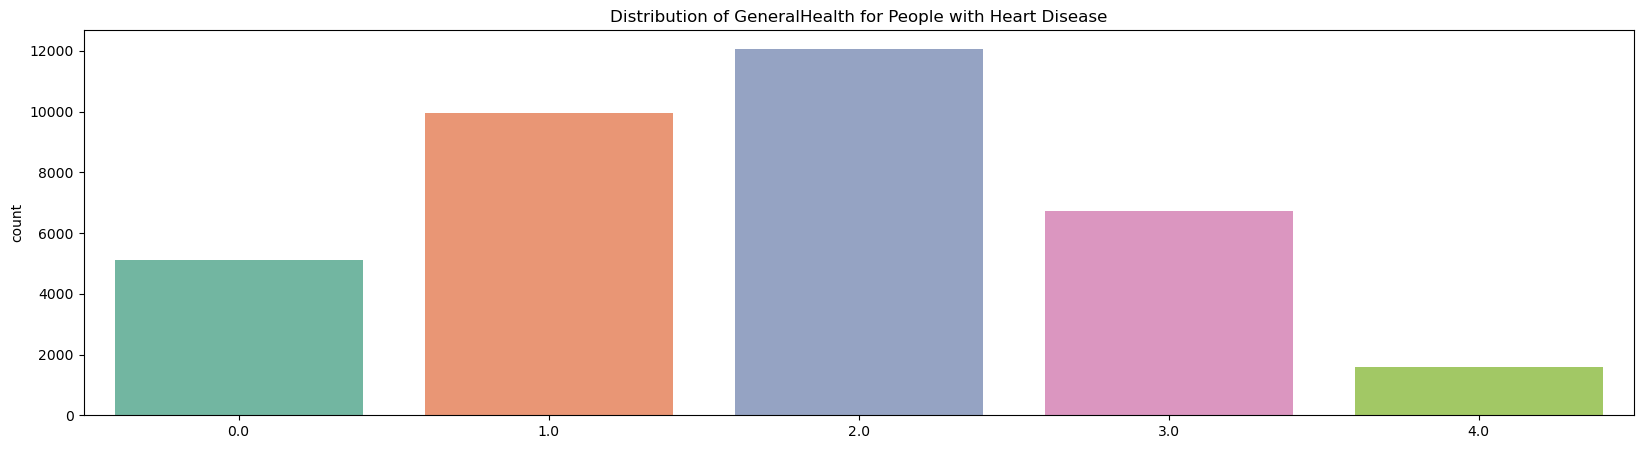

In [62]:

gen_health_yes = combined_df[combined_df['HadHeartDisease'] == 1]['GeneralHealth_label__GeneralHealth']
gen_health_no = combined_df[combined_df['HadHeartDisease'] == 0]['GeneralHealth_label__GeneralHealth']
# see proportion for AgeCategory
plt.figure(figsize=(20,5))
sns.countplot(gen_health_yes, palette = 'Set2')
plt.xlabel('')
plt.title('Distribution of GeneralHealth for People with Heart Disease')

/Users/xiaogouzuomeng/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0.5, 1.0, 'Distribution of GeneralHealth for People with Heart Disease')

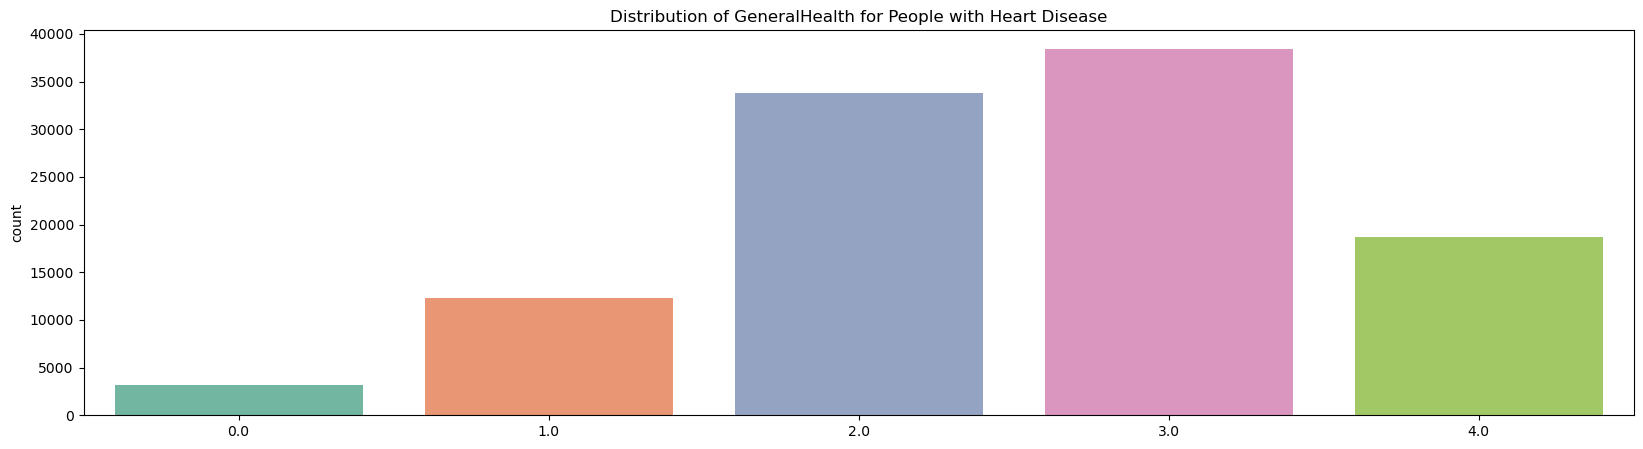

In [63]:
gen_health_yes = combined_df[combined_df['HadHeartDisease'] == 1]['GeneralHealth_label__GeneralHealth']
gen_health_no = combined_df[combined_df['HadHeartDisease'] == 0]['GeneralHealth_label__GeneralHealth']
# see proportion for AgeCategory
plt.figure(figsize=(20,5))
sns.countplot(gen_health_no, palette = 'Set2')
plt.xlabel('')
plt.title('Distribution of GeneralHealth for People with Heart Disease')

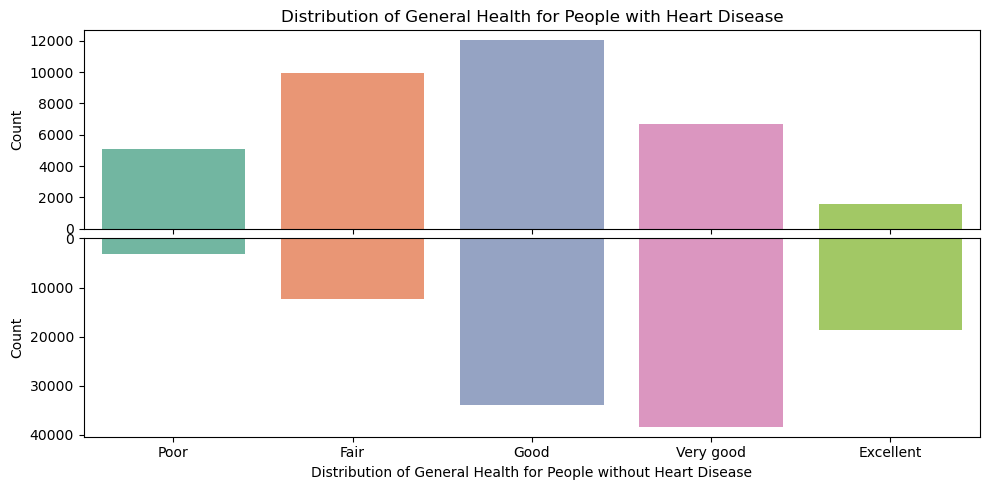

In [143]:
labels = ['Poor', 'Fair', 'Good', 'Very good', 'Excellent']
fig, axes = plt.subplots(2, 1, figsize=(10, 5), sharex=True, dpi=100)  # Changes here: 2 rows, 1 column

# Plot for people with heart disease
sns.countplot(x=gen_health_yes, palette='Set2', ax=axes[0])  # Use ax=axes[0] for the first subplot
axes[0].set_title('Distribution of General Health for People with Heart Disease')
axes[0].set_ylabel('Count')
axes[0].set_xlabel('')

# Plot for people without heart disease
sns.countplot(x=gen_health_no, palette='Set2', ax=axes[1])  # Use ax=axes[1] for the second subplot
axes[1].set_ylabel('Count')
axes[1].set_xlabel('Distribution of General Health for People without Heart Disease')
axes[1].invert_yaxis()  # Invert the second plot
plt.xticks(range(len(labels)), labels)  # Rotate for better legibility

plt.tight_layout()  # Adjust layout to prevent overlap
plt.subplots_adjust(hspace=0.05) 
plt.show()

Text(0.5, 1.0, 'Correlation Heatmap on continous and ordinal data')

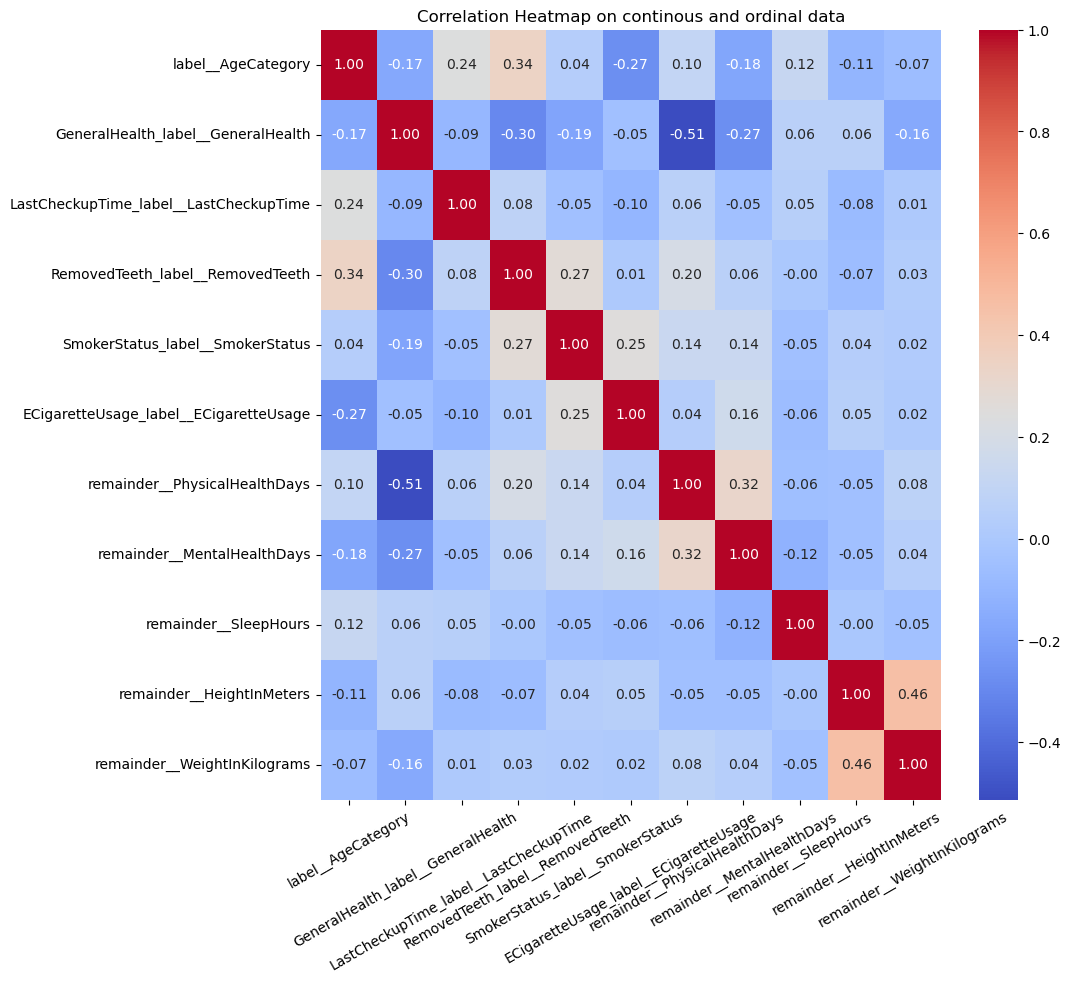

In [64]:
continuous_cols = [col for col in combined_df.columns if 'remainder' in col or 'label' in col]
# correlation of the numerics
plt.figure(figsize=(10,10))
sns.heatmap(combined_df[continuous_cols].corr(), annot = True, cmap = 'coolwarm', fmt = '.2f')
# tilt the x-axis labels
plt.xticks(rotation = 30)
plt.title("Correlation Heatmap on continous and ordinal data")